In [92]:
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [82]:
#Assets
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']

# Download historical price data

data = yf.download(tickers, start='2019-01-01', end='2024-01-01')['Adj Close']


# Identify tickers with missing data
failed_tickers = [ticker for ticker in tickers if ticker not in data.columns or data[ticker].isna().all()]

# Retry failed downloads
for ticker in failed_tickers:
    new_data = yf.download(ticker, start='2020-01-01', end='2023-01-01')['Adj Close']
    data[ticker] = new_data

# Calculate daily returns
if not data.empty:
    returns = data.pct_change(fill_method=None).dropna()
else:
    pass


[*********************100%***********************]  5 of 5 completed


In [83]:
factors = pd.read_csv('fama_french_factors.csv', sep=';')

# Convert 'Column1' to datetime format
factors['Date'] = pd.to_datetime(factors['Column1'], format='%Y%m')  # Convert YYYYMM to datetime
factors.set_index('Date', inplace=True)  # Set the new datetime column as the index
factors.drop('Column1', axis=1, inplace=True)  # Drop the original 'Column1'

aligned_data = returns.join(factors, how='inner')

In [84]:
betas = {}
for ticker in tickers:
    X = sm.add_constant(aligned_data[['Mkt-RF', 'SMB', 'HML']])  # Factors
    y = aligned_data[ticker]  # Asset returns
    model = sm.OLS(y, X).fit()  # Fit the regression model
    betas[ticker] = model.params  # Store the regression coefficients

print(betas)


{'AAPL': const     0.006523
Mkt-RF   -0.000005
SMB       0.000005
HML       0.000011
dtype: float64, 'MSFT': const     0.001599
Mkt-RF    0.000002
SMB      -0.000010
HML       0.000013
dtype: float64, 'GOOGL': const     0.003518
Mkt-RF   -0.000002
SMB      -0.000002
HML       0.000010
dtype: float64, 'AMZN': const     2.280731e-03
Mkt-RF   -4.339360e-10
SMB       7.099879e-06
HML       1.995700e-05
dtype: float64, 'TSLA': const     0.002593
Mkt-RF    0.000001
SMB       0.000014
HML       0.000037
dtype: float64}


In [85]:
aligned_data.shape

(41, 9)

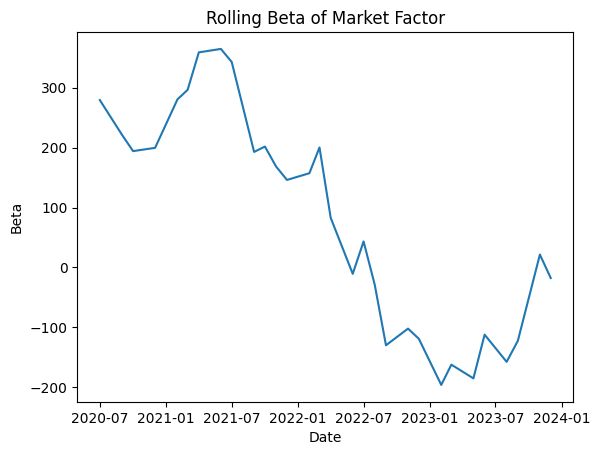

In [88]:
rolling_beta = aligned_data['Mkt-RF'].rolling(window=12).mean() # 12-month rolling average of the market factor

plt.plot(rolling_beta)
plt.title('Rolling Beta of Market Factor')
plt.xlabel('Date')
plt.ylabel('Beta')
plt.show()

# Implementing Black-Literman Model

In [91]:
# Market capitalization weights (example values)
market_caps = [2.5e12, 2.3e12, 1.8e12, 1.6e12, 800e9]
weights = np.array(market_caps) / sum(market_caps)

# Covariance matrix of returns
cov_matrix = returns.cov()

# Equilibrium returns
risk_aversion = 3  # Example risk aversion level
eq_returns = risk_aversion * np.dot(cov_matrix, weights)

In [ ]:
def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Weights sum to 1
bounds = [(0, 1) for _ in range(len(tickers))]  # No short selling

# Optimize
opt_result = minimize(portfolio_variance, x0=np.ones(len(tickers)) / len(tickers),
                      args=(cov_matrix,), method='SLSQP', constraints=constraints, bounds=bounds)
optimal_weights = opt_result.x


[0.2 0.2 0.2 0.2 0.2]


## Systematic Backtesting

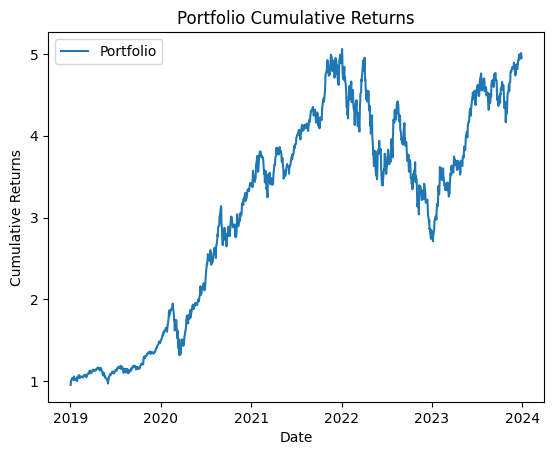

In [94]:
# Portfolio returns
portfolio_returns = (returns * optimal_weights).sum(axis=1)

# Cumulative returns
cumulative_returns = (1 + portfolio_returns).cumprod()

plt.plot(cumulative_returns, label='Portfolio')
plt.title('Portfolio Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()